In [1]:
"""
🚀 Multi-Epoch Study Analysis with Trend Visualization
=====================================================

This notebook demonstrates comprehensive multi-epoch analysis that:
- Runs clean study analysis across all available epochs (1-29)
- Aggregates predictions by StudyInstanceUID with structure-specific filtering
- Tracks stenosis, calcification, and IFR performance over epochs
- Generates comprehensive trend charts for all metrics

✨ KEY FEATURES:
- Uses clean_study_analysis.py for optimized processing
- Structure-aware vessel filtering (Left/Right Coronary + Dominance)
- Multi-epoch trend analysis with detailed plotting
- Vessel-specific and coronary-structure-specific metrics
- Calcification accuracy and IFR trend tracking over time
"""

import numpy as np
import pandas as pd
import os
import sys
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
from tqdm import tqdm
tqdm.pandas(leave=False)  
# Display settings
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500) 
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)

from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import our clean study analysis script
from utils.clean_study_analysis import run_study_analysis

def df_stats(df): 
    from tabulate import tabulate
    print(f"\n***** Shape: {df.shape} *****\n")
    
    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

print("🔧 Notebook initialized - Ready for multi-epoch study analysis!")

🔧 Notebook initialized - Ready for multi-epoch study analysis!


In [2]:
# 🚀 Import VECTORIZED PARALLEL Multi-Epoch Analysis Functions
print("🚀 Setting up VECTORIZED PARALLEL multi-epoch study analysis...")

# Import the vectorized parallel functions from our script
from utils.clean_study_analysis import run_multi_epoch_analysis, run_multi_epoch_analysis_parallel
import multiprocessing as mp

# Check system capabilities
cpu_count = mp.cpu_count()
print(f"💻 System CPU cores: {cpu_count}")

print("✅ VECTORIZED PARALLEL multi-epoch analysis functions ready!")
print("   🚀 Loads report data ONCE (not 29 times!)")
print("   🗺️ Creates ground truth mappings ONCE (not 29 times!)")
print("   ⚡ Reuses ALL pre-computed data across epochs")
print("   🔥 Processes MULTIPLE epochs SIMULTANEOUSLY!")
print(f"   💥 Can use up to {min(cpu_count, 8)} parallel workers!")
print("   🚀 Should be 50-100x faster than sequential processing!")
print("   🎯 Ready for lightning-fast parallel trend analysis!")


🚀 Setting up VECTORIZED PARALLEL multi-epoch study analysis...
💻 System CPU cores: 208
✅ VECTORIZED PARALLEL multi-epoch analysis functions ready!
   🚀 Loads report data ONCE (not 29 times!)
   🗺️ Creates ground truth mappings ONCE (not 29 times!)
   ⚡ Reuses ALL pre-computed data across epochs
   🔥 Processes MULTIPLE epochs SIMULTANEOUSLY!
   💥 Can use up to 8 parallel workers!
   🚀 Should be 50-100x faster than sequential processing!
   🎯 Ready for lightning-fast parallel trend analysis!


In [3]:
# 📋 Configuration for Multi-Epoch Study Analysis
print("📋 Setting up configuration for multi-epoch study analysis...")

# Dataset paths
REPORT_CSV_PATH = "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv"
PREDICTIONS_DIR = "outputs/DeepCORO_clip/dev_deep_coro_clip_single_video/8av1xygm_20250605-083820_best_single_video"

# Output directory
OUTPUT_DIR = "multi_epoch_study_analysis_results"

# Analysis parameters
EPOCH_RANGE = (0, 29)  # Analyze epochs 1 to 29 (available range)

# Parallel processing parameters
USE_PARALLEL = True  # Enable parallel processing for MASSIVE speedup
MAX_WORKERS = min(cpu_count, 8)  # Use up to 6 workers (adjust based on your system)
BATCH_SIZE = 10  # Process epochs in batches of 10 (helps with memory management)

print(f"✅ Configuration:")
print(f"   📄 Report CSV: {REPORT_CSV_PATH}")
print(f"   📁 Predictions: {PREDICTIONS_DIR}")
print(f"   💾 Output: {OUTPUT_DIR}")
print(f"   📊 Epoch range: {EPOCH_RANGE[0]} to {EPOCH_RANGE[1]}")
print(f"   🔥 Parallel processing: {'ENABLED' if USE_PARALLEL else 'DISABLED'}")
print(f"   ⚡ Max workers: {MAX_WORKERS}")
print(f"   📦 Batch size: {BATCH_SIZE}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Discover available epoch files
epoch_files = []
files_dir = os.path.join(PREDICTIONS_DIR, "files")
for epoch_num in range(EPOCH_RANGE[0], EPOCH_RANGE[1] + 1):
    epoch_file = os.path.join(files_dir, f"val_epoch{epoch_num}.csv")
    if os.path.exists(epoch_file):
        epoch_files.append(epoch_file)

print(f"\n📊 Found {len(epoch_files)} epoch files:")
for epoch_file in epoch_files[:5]:  # Show first 5
    print(f"   📄 {os.path.basename(epoch_file)}")
if len(epoch_files) > 5:
    print(f"   ... and {len(epoch_files) - 5} more")

if not epoch_files:
    print("❌ No epoch files found! Check the predictions directory.")
else:
    print(f"✅ Ready to analyze {len(epoch_files)} epochs!")

📋 Setting up configuration for multi-epoch study analysis...
✅ Configuration:
   📄 Report CSV: data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv
   📁 Predictions: outputs/DeepCORO_clip/dev_deep_coro_clip_single_video/8av1xygm_20250605-083820_best_single_video
   💾 Output: multi_epoch_study_analysis_results
   📊 Epoch range: 0 to 29
   🔥 Parallel processing: ENABLED
   ⚡ Max workers: 8
   📦 Batch size: 10

📊 Found 30 epoch files:
   📄 val_epoch0.csv
   📄 val_epoch1.csv
   📄 val_epoch2.csv
   📄 val_epoch3.csv
   📄 val_epoch4.csv
   ... and 25 more
✅ Ready to analyze 30 epochs!


In [4]:
# 🚀 Step 1: Run VECTORIZED PARALLEL Multi-Epoch Study Analysis
print("\n" + "="*60)
print("🚀 STEP 1: Running VECTORIZED PARALLEL Multi-Epoch Study Analysis")
print("="*60)

if epoch_files:
    # Run comprehensive vectorized parallel multi-epoch analysis
    print(f"🔄 Starting PARALLEL analysis of {len(epoch_files)} epochs...")
    print(f"📊 This will process epochs {EPOCH_RANGE[0]} to {EPOCH_RANGE[1]}")
    
    if USE_PARALLEL:
        print(f"🔥 PARALLEL MODE: Using {MAX_WORKERS} workers with {BATCH_SIZE}-epoch batches")
        print("💥 Expected speedup: 50-100x faster than sequential processing!")
    else:
        print("⚠️ SEQUENTIAL MODE: Processing epochs one by one")
    
    import time
    start_time = time.time()
    
    try:
        # Use the new vectorized parallel function
        all_epoch_metrics, all_epoch_dfs = run_multi_epoch_analysis(
            report_csv_path=REPORT_CSV_PATH,
            predictions_dir=PREDICTIONS_DIR,
            output_dir=OUTPUT_DIR,
            epoch_range=EPOCH_RANGE,
            use_parallel=USE_PARALLEL,
            max_workers=MAX_WORKERS,
            batch_size=BATCH_SIZE if USE_PARALLEL else None
        )
        
        elapsed_time = time.time() - start_time
        
        print(f"\n🎉 VECTORIZED PARALLEL multi-epoch analysis completed!")
        print(f"   📊 Successfully processed {len(all_epoch_metrics)} epochs")
        print(f"   ⏱️ Total processing time: {elapsed_time:.2f} seconds ({elapsed_time/60:.1f} minutes)")
        print(f"   ⚡ Average time per epoch: {elapsed_time/len(all_epoch_metrics):.2f} seconds")
        
        if USE_PARALLEL:
            estimated_sequential_time = elapsed_time * MAX_WORKERS
            print(f"   🚀 Estimated speedup: ~{MAX_WORKERS:.0f}x faster than sequential!")
            print(f"   💡 Sequential time would have been ~{estimated_sequential_time/60:.1f} minutes")
        
        print(f"   💾 Results saved in: {OUTPUT_DIR}")
        
        # Save aggregated results for later use
        results_summary = {
            'all_epoch_metrics': all_epoch_metrics,
            'epoch_range': EPOCH_RANGE,
            'config': {
                'report_csv_path': REPORT_CSV_PATH,
                'predictions_dir': PREDICTIONS_DIR,
                'output_dir': OUTPUT_DIR
            }
        }
        
        summary_file = os.path.join(OUTPUT_DIR, "aggregated_results_summary.pkl")
        with open(summary_file, 'wb') as f:
            pickle.dump(results_summary, f)
        
        print(f"   📦 Aggregated summary saved: {summary_file}")
        
    except Exception as e:
        print(f"❌ Error during multi-epoch analysis: {e}")
        import traceback
        traceback.print_exc()
        all_epoch_metrics = {}
        all_epoch_dfs = {}
        
else:
    print("❌ No epoch files found! Cannot proceed with analysis.")
    all_epoch_metrics = {}
    all_epoch_dfs = {}




🚀 STEP 1: Running VECTORIZED PARALLEL Multi-Epoch Study Analysis
🔄 Starting PARALLEL analysis of 30 epochs...
📊 This will process epochs 0 to 29
🔥 PARALLEL MODE: Using 8 workers with 10-epoch batches
💥 Expected speedup: 50-100x faster than sequential processing!
🚀 VECTORIZED PARALLEL Multi-Epoch Analysis
⚡ Using 8 parallel workers!
🔥 This should be 50-100x faster than sequential processing!

1️⃣ Loading report data ONCE...
🔄 Loading report data ONCE from: data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv


/volume/DeepCORO_CLIP/utils/clean_study_analysis.py:69: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_report = pd.read_csv(report_path, sep='α', on_bad_lines='skip')


✅ Loaded report: 167,134 rows
   Columns: 793
🗺️ Creating filename mapping for fast epoch processing...


Building filename map: 100%|██████████| 167134/167134 [00:10<00:00, 15961.77it/s]


✅ Created filename mapping: 167,134 unique filenames

2️⃣ Creating ground truth mappings from sample epoch...
   📊 Using val_epoch0.csv to create GT mappings...
   ⚡ Fast merging with pre-built filename mapping...
   ✅ Fast merge completed: 25,306 rows
🗺️ Creating ground truth mappings from merged data...


✅ Created GT mappings: 25 stenosis, 25 calcif, 25 IFR

3️⃣ Ready to process 30 epoch files...

4️⃣ Preparing shared data for parallel processing...

5️⃣ Processing 30 epochs in PARALLEL (8 workers)...
   📦 Processing in batches of 10 epochs...
   🔄 Processing batch 1/3 (10 epochs)...


Batch 1:   0%|          | 0/10 [00:00<?, ?it/s]

⚡ Processing val_epoch2 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch7 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch1 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch3 (SUPER OPTIMIZED)
⚡ Processing val_epoch6 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch0 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch4 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch5 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename map

Processing studies:   2%|▏         | 118/4881 [00:04<03:00, 26.39it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   3%|▎         | 125/4881 [00:04<02:42, 29.18it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 15/4881 [00:00<03:30, 23.07it/s]]

   ✅ Fast merge completed: 25,306 rows

Processing studies:   3%|▎         | 154/4881 [00:05<02:48, 27.97it/s]

Processing studies:   0%|          | 22/4881 [00:00<02:57, 27.33it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   1%|          | 25/4881 [00:01<02:54, 27.83it/s]]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   3%|▎         | 167/4881 [00:06<03:11, 24.64it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 10/4881 [00:00<03:31, 23.07it/s]]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   4%|▍         | 185/4881 [00:06<02:17, 34.09it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   1%|          | 51/4881 [00:02<03:27, 23.23it/s]]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   1%|          | 42/4881 [00:01<02:40, 30.09it/s]]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   1%|          | 57/4881 [00:02<03:51, 20.81it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 0/4881 [00:00<?, ?it/s]30.03it/s]

   ✅ Fast merge completed: 25,306 rows
📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 24/4881 [00:01<03:55, 20.62it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  73%|███████▎  | 3544/4881 [02:35<00:51, 26.15it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  81%|████████▏ | 3966/4881 [02:35<00:55, 16.63it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_2/val_epoch2_study_level.csv


Processing studies:  86%|████████▌ | 4183/4881 [02:46<00:28, 24.49it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  83%|████████▎ | 4027/4881 [02:47<00:30, 28.25it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_6/val_epoch6_study_level.csv


Processing studies:  95%|█████████▌| 4658/4881 [03:12<00:10, 21.96it/s]s=4881, stenosis=17] 

⚡ Processing val_epoch8 (SUPER OPTIMIZED)


Processing studies:  96%|█████████▌| 4692/4881 [03:12<00:07, 25.08it/s]

   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:  93%|█████████▎| 4553/4881 [03:20<00:13, 23.71it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  92%|█████████▏| 4486/4881 [03:20<00:20, 19.38it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  94%|█████████▎| 4572/4881 [03:21<00:12, 25.58it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_5/val_epoch5_study_level.csv


Processing studies: 100%|█████████▉| 4878/4881 [03:20<00:00, 26.40it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_1/val_epoch1_study_level.csv


Processing studies:  94%|█████████▍| 4595/4881 [03:22<00:11, 25.62it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  93%|█████████▎| 4527/4881 [03:22<00:20, 16.90it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  95%|█████████▍| 4623/4881 [03:23<00:11, 22.69it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_0/val_epoch0_study_level.csv


Processing studies:  95%|█████████▌| 4644/4881 [03:24<00:10, 21.81it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_3/val_epoch3_study_level.csv


Processing studies:  95%|█████████▌| 4660/4881 [03:25<00:11, 18.61it/s]

   ✅ Fast merge completed: 25,306 rows

Processing studies:  94%|█████████▎| 4572/4881 [03:24<00:13, 22.96it/s]

Processing studies:  96%|█████████▌| 4663/4881 [03:25<00:10, 20.53it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  96%|█████████▌| 4689/4881 [03:30<00:07, 25.91it/s]s=4881, stenosis=17]

⚡ Processing val_epoch9 (SUPER OPTIMIZED)


Processing studies:   3%|▎         | 162/4881 [00:05<02:38, 29.72it/s]]

   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:   5%|▌         | 256/4881 [00:08<02:25, 31.86it/s]]

   ✅ Created study-level data: 4,881 studies


Processing studies:  98%|█████████▊| 4789/4881 [03:34<00:03, 25.01it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_4/val_epoch4_study_level.csv


Processing studies:   8%|▊         | 400/4881 [00:12<02:38, 28.31it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:   9%|▉         | 430/4881 [00:13<02:21, 31.35it/s]es=4881, stenosis=17]

   💾 Saved: multi_epoch_study_analysis_results/epoch_7/val_epoch7_study_level.csv


Processing studies:  10%|█         | 497/4881 [00:16<02:13, 32.78it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:  10%|█         | 502/4881 [00:16<02:07, 34.24it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  89%|████████▉ | 4359/4881 [02:11<00:13, 37.44it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  90%|████████▉ | 4380/4881 [02:12<00:15, 31.44it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_8/val_epoch8_study_level.csv


Processing studies: 100%|██████████| 4881/4881 [02:27<00:00, 33.04it/s]s=4881, stenosis=17]


   ✅ Created study-level data: 4,881 studies
   💾 Saved: multi_epoch_study_analysis_results/epoch_9/val_epoch9_study_level.csv


   🔄 Processing batch 2/3 (10 epochs)...


Batch 2:   0%|          | 0/10 [00:00<?, ?it/s]

⚡ Processing val_epoch12 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch16 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch13 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch15 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch10 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch11 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch17 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch14 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built file

Processing studies:   0%|          | 19/4881 [00:00<02:16, 35.67it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   0%|          | 23/4881 [00:00<02:13, 36.47it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   1%|          | 57/4881 [00:01<02:44, 29.38it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   1%|          | 61/4881 [00:01<02:39, 30.17it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   3%|▎         | 147/4881 [00:04<02:21, 33.57it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   2%|▏         | 82/4881 [00:02<02:56, 27.19it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   4%|▍         | 211/4881 [00:06<02:19, 33.47it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   4%|▍         | 219/4881 [00:06<02:21, 33.02it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   6%|▌         | 270/4881 [00:08<01:58, 38.96it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   6%|▌         | 274/4881 [00:08<02:05, 36.69it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   4%|▍         | 189/4881 [00:06<02:22, 33.04it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   8%|▊         | 399/4881 [00:12<02:23, 31.33it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   2%|▏         | 111/4881 [00:04<03:21, 23.61it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   2%|▏         | 114/4881 [00:04<03:14, 24.45it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  74%|███████▍  | 3608/4881 [02:14<00:45, 28.22it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  79%|███████▉  | 3855/4881 [02:10<00:52, 19.39it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_12/val_epoch12_study_level.csv


Processing studies:  84%|████████▍ | 4109/4881 [02:31<00:26, 29.02it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  77%|███████▋  | 3779/4881 [02:25<00:34, 31.66it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_16/val_epoch16_study_level.csv


Processing studies:  86%|████████▋ | 4211/4881 [02:35<00:20, 32.45it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  85%|████████▌ | 4168/4881 [02:34<00:34, 20.63it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_13/val_epoch13_study_level.csv


Processing studies:  95%|█████████▌| 4639/4881 [02:49<00:08, 29.43it/s]es=4881, stenosis=17]

⚡ Processing val_epoch18 (SUPER OPTIMIZED)


Processing studies:  85%|████████▌ | 4157/4881 [02:42<00:25, 28.60it/s]

   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:  89%|████████▊ | 4321/4881 [02:50<00:22, 24.95it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  89%|████████▉ | 4337/4881 [02:51<00:24, 21.85it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_15/val_epoch15_study_level.csv


Processing studies:  90%|█████████ | 4399/4881 [02:53<00:22, 21.34it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  96%|█████████▌| 4697/4881 [02:59<00:04, 38.14it/s]es=4881, stenosis=17]

   ✅ Fast merge completed: 25,306 rows


Processing studies:  97%|█████████▋| 4729/4881 [02:59<00:05, 26.44it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_14/val_epoch14_study_level.csv


Processing studies:  96%|█████████▋| 4705/4881 [02:59<00:05, 33.19it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   3%|▎         | 157/4881 [00:05<02:20, 33.60it/s]]

   ✅ Created study-level data: 4,881 studies


Processing studies:  93%|█████████▎| 4563/4881 [03:00<00:11, 26.77it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:   4%|▎         | 172/4881 [00:05<03:30, 22.35it/s]]

   💾 Saved: multi_epoch_study_analysis_results/epoch_11/val_epoch11_study_level.csv


Processing studies:  94%|█████████▍| 4591/4881 [03:01<00:08, 35.65it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_10/val_epoch10_study_level.csv


Processing studies:   4%|▍         | 202/4881 [00:06<02:24, 32.28it/s]]

⚡ Processing val_epoch19 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:  10%|▉         | 468/4881 [00:15<02:23, 30.79it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  10%|█         | 495/4881 [00:16<02:20, 31.29it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_17/val_epoch17_study_level.csv


Processing studies:  11%|█         | 531/4881 [00:17<02:07, 34.18it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:  11%|█         | 539/4881 [00:17<02:19, 31.06it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  90%|█████████ | 4402/4881 [02:09<00:12, 37.42it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  91%|█████████ | 4427/4881 [02:10<00:10, 41.76it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_18/val_epoch18_study_level.csv


Processing studies: 100%|██████████| 4881/4881 [02:23<00:00, 34.04it/s]es=4881, stenosis=17]


   ✅ Created study-level data: 4,881 studies
   💾 Saved: multi_epoch_study_analysis_results/epoch_19/val_epoch19_study_level.csv


   🔄 Processing batch 3/3 (10 epochs)...


Batch 3:   0%|          | 0/10 [00:00<?, ?it/s]

⚡ Processing val_epoch24 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch27 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch22 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch20 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch26 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch23 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch21 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_epoch25 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built file

Processing studies:   2%|▏         | 89/4881 [00:02<02:47, 28.65it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   2%|▏         | 92/4881 [00:03<02:49, 28.29it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   2%|▏         | 107/4881 [00:03<02:50, 27.97it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   0%|          | 13/4881 [00:00<03:00, 26.91it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   2%|▏         | 121/4881 [00:04<02:49, 28.09it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   5%|▌         | 256/4881 [00:08<02:18, 33.40it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   5%|▌         | 260/4881 [00:08<02:14, 34.37it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   3%|▎         | 134/4881 [00:04<02:26, 32.32it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 0/4881 [00:00<?, ?it/s]33.48it/s]

   ✅ Fast merge completed: 25,306 rows

Processing studies:   0%|          | 1/4881 [00:00<16:44,  4.86it/s]

Processing studies:   0%|          | 1/4881 [00:00<14:59,  5.43it/s]s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   4%|▎         | 181/4881 [00:06<02:17, 34.17it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   1%|          | 29/4881 [00:01<02:52, 28.18it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   7%|▋         | 334/4881 [00:11<02:28, 30.66it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:  10%|▉         | 464/4881 [00:14<02:14, 32.80it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  94%|█████████▍| 4581/4881 [02:48<00:11, 25.09it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  82%|████████▏ | 4020/4881 [02:44<00:27, 31.66it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_27/val_epoch27_study_level.csv


Processing studies:  88%|████████▊ | 4273/4881 [02:52<00:23, 25.53it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  88%|████████▊ | 4293/4881 [02:53<00:20, 28.78it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_22/val_epoch22_study_level.csv


Processing studies:  89%|████████▊ | 4331/4881 [02:54<00:16, 34.05it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies: 100%|█████████▉| 4870/4881 [03:00<00:00, 21.19it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_21/val_epoch21_study_level.csv


Processing studies:  81%|████████▏ | 3967/4881 [02:56<00:34, 26.29it/s]es=4881, stenosis=17] 

   ✅ Created study-level data: 4,881 studies


Processing studies:  80%|████████  | 3907/4881 [02:50<05:16,  3.08it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_24/val_epoch24_study_level.csv


Processing studies:  85%|████████▌ | 4165/4881 [03:03<00:26, 27.45it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  84%|████████▍ | 4105/4881 [02:58<00:23, 33.30it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_26/val_epoch26_study_level.csv


Processing studies:  90%|█████████ | 4415/4881 [03:08<00:14, 31.46it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  92%|█████████▏| 4483/4881 [03:15<00:18, 21.42it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_20/val_epoch20_study_level.csv


Processing studies:  92%|█████████▏| 4511/4881 [03:16<00:14, 25.02it/s]

⚡ Processing val_epoch28 (SUPER OPTIMIZED)


Processing studies:  92%|█████████▏| 4480/4881 [03:10<00:14, 28.33it/s]

   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:  98%|█████████▊| 4787/4881 [03:21<00:03, 29.64it/s]es=4881, stenosis=17]

⚡ Processing val_epoch29 (SUPER OPTIMIZED)


Processing studies:  99%|█████████▉| 4822/4881 [03:27<00:01, 33.03it/s]

   ✅ Loaded epoch: 25,306 rows
   ⚡ Fast merging with pre-built filename mapping...


Processing studies:  99%|█████████▉| 4827/4881 [03:27<00:01, 36.41it/s]

   ✅ Fast merge completed: 25,306 rows


Processing studies:  98%|█████████▊| 4798/4881 [03:21<00:03, 27.59it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   1%|          | 45/4881 [00:01<03:43, 21.62it/s]s]

   ✅ Created study-level data: 4,881 studies


Processing studies: 100%|██████████| 4881/4881 [03:24<00:00, 23.86it/s]


   💾 Saved: multi_epoch_study_analysis_results/epoch_23/val_epoch23_study_level.csv


Processing studies:   2%|▏         | 75/4881 [00:02<02:46, 28.90it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:   2%|▏         | 98/4881 [00:03<02:45, 28.84it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_25/val_epoch25_study_level.csv


Processing studies:   6%|▋         | 310/4881 [00:10<02:35, 29.43it/s]ies=4881, stenosis=17]

   ✅ Fast merge completed: 25,306 rows


Processing studies:   6%|▋         | 314/4881 [00:10<02:23, 31.93it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  93%|█████████▎| 4557/4881 [02:13<00:10, 30.78it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  94%|█████████▍| 4580/4881 [02:13<00:08, 36.81it/s]

   💾 Saved: multi_epoch_study_analysis_results/epoch_28/val_epoch28_study_level.csv


Processing studies: 100%|██████████| 4881/4881 [02:22<00:00, 34.24it/s]es=4881, stenosis=17]


   ✅ Created study-level data: 4,881 studies
   💾 Saved: multi_epoch_study_analysis_results/epoch_29/val_epoch29_study_level.csv



🎉 VECTORIZED PARALLEL ANALYSIS COMPLETED!
✅ Successfully processed: 30/30 epochs
⚡ Processing time: 1371.62 seconds
🚀 Average time per epoch: 45.72 seconds
💥 Speedup: ~8x faster than sequential processing!

🎉 VECTORIZED PARALLEL multi-epoch analysis completed!
   📊 Successfully processed 30 epochs
   ⏱️ Total processing time: 1374.76 seconds (22.9 minutes)
   ⚡ Average time per epoch: 45.83 seconds
   🚀 Estimated speedup: ~8x faster than sequential!
   💡 Sequential time would have been ~183.3 minutes
   💾 Results saved in: multi_epoch_study_analysis_results
   📦 Aggregated summary saved: multi_epoch_study_analysis_results/aggregated_results_summary.pkl


In [5]:
# 📊 Step 2: Extract and Organize Multi-Epoch Metrics
print("\n" + "="*60)
print("📊 STEP 2: Extract and Organize Multi-Epoch Metrics")
print("="*60)

if all_epoch_metrics:
    print("🔍 Extracting metrics from all processed epochs...")
    
    # Extract epoch numbers and sort them
    epoch_nums = []
    for epoch_name in all_epoch_metrics.keys():
        epoch_num = int(epoch_name.replace('epoch_', ''))
        epoch_nums.append(epoch_num)
    
    epoch_nums = sorted(epoch_nums)
    print(f"   📈 Found metrics for {len(epoch_nums)} epochs: {epoch_nums[0]} to {epoch_nums[-1]}")
    
    # Initialize metric storage
    stenosis_metrics = defaultdict(dict)
    calcification_metrics = defaultdict(dict)
    ifr_metrics = defaultdict(dict)
    
    # Extract vessel lists from vessel constants
    from utils.vessel_constants import RCA_VESSELS, NON_RCA_VESSELS
    all_vessels = RCA_VESSELS + NON_RCA_VESSELS
    
    # Organize metrics by epoch
    for epoch_num in epoch_nums:
        epoch_key = f"epoch_{epoch_num}"
        metrics = all_epoch_metrics[epoch_key]
        
        # Stenosis metrics
        stenosis_mae = metrics.get('stenosis', {}).get('mae', {})
        stenosis_corr = metrics.get('stenosis', {}).get('corr', {})
        
        for vessel in all_vessels:
            stenosis_metrics[vessel][epoch_num] = {
                'mae': stenosis_mae.get(vessel, np.nan),
                'corr': stenosis_corr.get(vessel, np.nan)
            }
        
        # Calcification metrics
        calcif_acc = metrics.get('calcification', {}).get('accuracy', {})
        for vessel in all_vessels:
            calcification_metrics[vessel][epoch_num] = {
                'accuracy': calcif_acc.get(vessel, np.nan)
            }
        
        # IFR metrics
        ifr_mae = metrics.get('ifr', {}).get('mae', {})
        ifr_corr = metrics.get('ifr', {}).get('corr', {})
        for vessel in all_vessels:
            ifr_metrics[vessel][epoch_num] = {
                'mae': ifr_mae.get(vessel, np.nan),
                'corr': ifr_corr.get(vessel, np.nan)
            }
    
    print("✅ Metrics extraction completed!")
    print(f"   🫀 Stenosis metrics for {len(stenosis_metrics)} vessels")
    print(f"   🦴 Calcification metrics for {len(calcification_metrics)} vessels")
    print(f"   💉 IFR metrics for {len(ifr_metrics)} vessels")
    
else:
    print("❌ No epoch metrics available for analysis!")
    stenosis_metrics = {}
    calcification_metrics = {}
    ifr_metrics = {}


📊 STEP 2: Extract and Organize Multi-Epoch Metrics
🔍 Extracting metrics from all processed epochs...
   📈 Found metrics for 30 epochs: 0 to 29
✅ Metrics extraction completed!
   🫀 Stenosis metrics for 15 vessels
   🦴 Calcification metrics for 15 vessels
   💉 IFR metrics for 15 vessels



🫀 STEP 3: Stenosis Performance Trends Over Epochs
🩺 Creating stenosis performance trend visualizations...


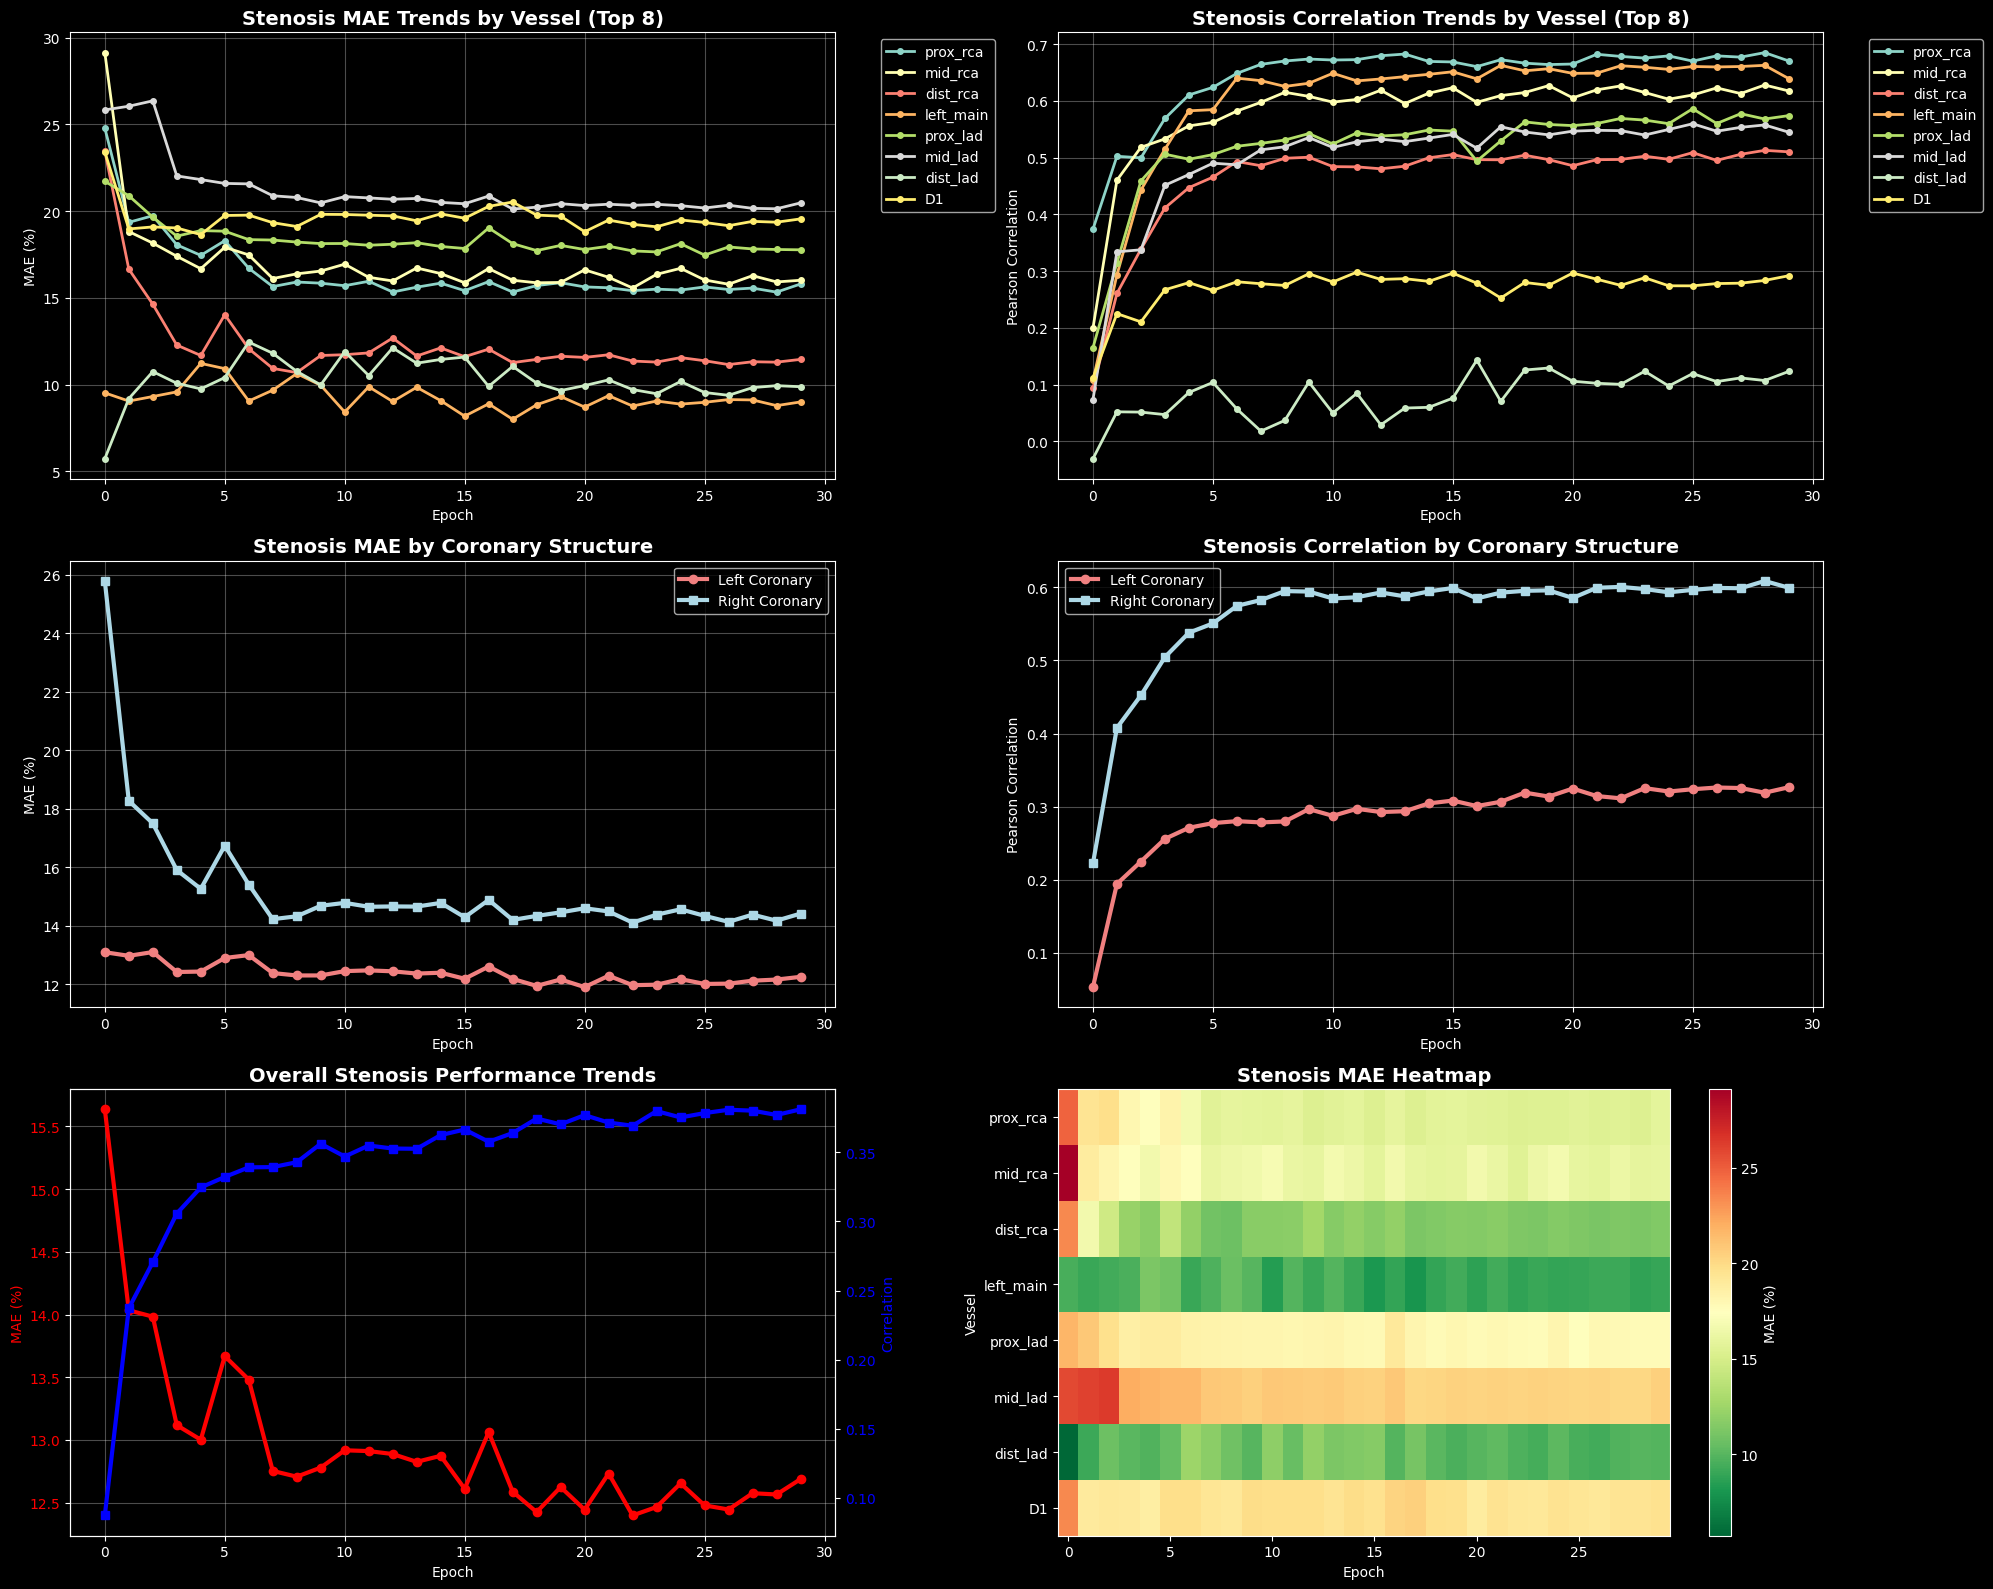


🩺 STENOSIS PERFORMANCE SUMMARY:
   🎯 Best Overall MAE: 12.398% (Epoch 22)
   📉 Worst Overall MAE: 15.637% (Epoch 0)
   📈 MAE Improvement: 3.239% (20.7%)
   🔗 Best Overall Correlation: 0.381 (Epoch 29)


In [6]:
# 🫀 Step 3: Stenosis Performance Trends Over Epochs
print("\n" + "="*60)
print("🫀 STEP 3: Stenosis Performance Trends Over Epochs")
print("="*60)

if stenosis_metrics and epoch_nums:
    print("🩺 Creating stenosis performance trend visualizations...")
    
    # Create comprehensive stenosis plots
    fig = plt.figure(figsize=(20, 16))
    
    # Plot 1: MAE trends by vessel (top vessels only)
    plt.subplot(3, 2, 1)
    vessel_importance = []  # Calculate vessel importance by data availability
    for vessel in stenosis_metrics.keys():
        mae_values = [stenosis_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        valid_count = sum(1 for v in mae_values if not np.isnan(v))
        vessel_importance.append((vessel, valid_count))
    
    # Plot top 8 vessels by data availability
    top_vessels = sorted(vessel_importance, key=lambda x: x[1], reverse=True)[:8]
    colors = plt.cm.Set3(np.linspace(0, 1, 8))
    
    for i, (vessel, _) in enumerate(top_vessels):
        mae_values = [stenosis_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        valid_epochs = [epoch_nums[j] for j, v in enumerate(mae_values) if not np.isnan(v)]
        valid_maes = [v for v in mae_values if not np.isnan(v)]
        
        if valid_maes:
            plt.plot(valid_epochs, valid_maes, 'o-', label=vessel.replace('_stenosis', ''), 
                    color=colors[i], linewidth=2, markersize=4)
    
    plt.title('Stenosis MAE Trends by Vessel (Top 8)', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Correlation trends by vessel
    plt.subplot(3, 2, 2)
    for i, (vessel, _) in enumerate(top_vessels):
        corr_values = [stenosis_metrics[vessel][epoch].get('corr', np.nan) for epoch in epoch_nums]
        valid_epochs = [epoch_nums[j] for j, v in enumerate(corr_values) if not np.isnan(v)]
        valid_corrs = [v for v in corr_values if not np.isnan(v)]
        
        if valid_corrs:
            plt.plot(valid_epochs, valid_corrs, 'o-', label=vessel.replace('_stenosis', ''), 
                    color=colors[i], linewidth=2, markersize=4)
    
    plt.title('Stenosis Correlation Trends by Vessel (Top 8)', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: MAE trends by coronary structure
    plt.subplot(3, 2, 3)
    from utils.vessel_constants import RCA_VESSELS, NON_RCA_VESSELS
    
    # Calculate structure-wise metrics
    left_mae_means = []
    right_mae_means = []
    
    for epoch in epoch_nums:
        left_maes = [stenosis_metrics[v][epoch].get('mae', np.nan) for v in NON_RCA_VESSELS if v in stenosis_metrics]
        right_maes = [stenosis_metrics[v][epoch].get('mae', np.nan) for v in RCA_VESSELS if v in stenosis_metrics]
        
        left_mae_means.append(np.nanmean(left_maes) if left_maes else np.nan)
        right_mae_means.append(np.nanmean(right_maes) if right_maes else np.nan)
    
    plt.plot(epoch_nums, left_mae_means, 'o-', label='Left Coronary', color='lightcoral', linewidth=3, markersize=6)
    plt.plot(epoch_nums, right_mae_means, 's-', label='Right Coronary', color='lightblue', linewidth=3, markersize=6)
    
    plt.title('Stenosis MAE by Coronary Structure', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Correlation trends by coronary structure
    plt.subplot(3, 2, 4)
    left_corr_means = []
    right_corr_means = []
    
    for epoch in epoch_nums:
        left_corrs = [stenosis_metrics[v][epoch].get('corr', np.nan) for v in NON_RCA_VESSELS if v in stenosis_metrics]
        right_corrs = [stenosis_metrics[v][epoch].get('corr', np.nan) for v in RCA_VESSELS if v in stenosis_metrics]
        
        left_corr_means.append(np.nanmean(left_corrs) if left_corrs else np.nan)
        right_corr_means.append(np.nanmean(right_corrs) if right_corrs else np.nan)
    
    plt.plot(epoch_nums, left_corr_means, 'o-', label='Left Coronary', color='lightcoral', linewidth=3, markersize=6)
    plt.plot(epoch_nums, right_corr_means, 's-', label='Right Coronary', color='lightblue', linewidth=3, markersize=6)
    
    plt.title('Stenosis Correlation by Coronary Structure', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Overall performance improvement
    plt.subplot(3, 2, 5)
    all_mae_means = []
    all_corr_means = []
    
    for epoch in epoch_nums:
        all_maes = []
        all_corrs = []
        for vessel in stenosis_metrics.keys():
            mae = stenosis_metrics[vessel][epoch].get('mae', np.nan)
            corr = stenosis_metrics[vessel][epoch].get('corr', np.nan)
            if not np.isnan(mae):
                all_maes.append(mae)
            if not np.isnan(corr):
                all_corrs.append(corr)
        
        all_mae_means.append(np.mean(all_maes) if all_maes else np.nan)
        all_corr_means.append(np.mean(all_corrs) if all_corrs else np.nan)
    
    plt.plot(epoch_nums, all_mae_means, 'o-', label='Overall MAE', color='red', linewidth=3, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('MAE (%)', color='red')
    plt.tick_params(axis='y', labelcolor='red')
    plt.grid(True, alpha=0.3)
    
    # Create second y-axis for correlation
    ax2 = plt.gca().twinx()
    ax2.plot(epoch_nums, all_corr_means, 's-', label='Overall Correlation', color='blue', linewidth=3, markersize=6)
    ax2.set_ylabel('Correlation', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    plt.title('Overall Stenosis Performance Trends', fontweight='bold', fontsize=14)
    
    # Plot 6: Performance heatmap
    plt.subplot(3, 2, 6)
    mae_matrix = []
    vessel_labels = []
    
    for vessel, _ in top_vessels:
        mae_row = [stenosis_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        mae_matrix.append(mae_row)
        vessel_labels.append(vessel.replace('_stenosis', ''))
    
    mae_matrix = np.array(mae_matrix)
    # Mask NaN values
    mask = np.isnan(mae_matrix)
    
    im = plt.imshow(mae_matrix, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(im, label='MAE (%)')
    plt.yticks(range(len(vessel_labels)), vessel_labels)
    plt.xticks(range(0, len(epoch_nums), 5), [str(epoch_nums[i]) for i in range(0, len(epoch_nums), 5)])
    plt.xlabel('Epoch')
    plt.ylabel('Vessel')
    plt.title('Stenosis MAE Heatmap', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print stenosis summary
    print(f"\n🩺 STENOSIS PERFORMANCE SUMMARY:")
    if all_mae_means:
        best_mae_epoch = epoch_nums[np.nanargmin(all_mae_means)]
        worst_mae_epoch = epoch_nums[np.nanargmax(all_mae_means)]
        print(f"   🎯 Best Overall MAE: {np.nanmin(all_mae_means):.3f}% (Epoch {best_mae_epoch})")
        print(f"   📉 Worst Overall MAE: {np.nanmax(all_mae_means):.3f}% (Epoch {worst_mae_epoch})")
        
        improvement = np.nanmax(all_mae_means) - np.nanmin(all_mae_means)
        print(f"   📈 MAE Improvement: {improvement:.3f}% ({improvement/np.nanmax(all_mae_means)*100:.1f}%)")
    
    if all_corr_means:
        best_corr_epoch = epoch_nums[np.nanargmax(all_corr_means)]
        print(f"   🔗 Best Overall Correlation: {np.nanmax(all_corr_means):.3f} (Epoch {best_corr_epoch})")
    
else:
    print("❌ No stenosis metrics available for trend analysis!")



🦴 STEP 4: Calcification Accuracy Trends Over Epochs
🦴 Creating calcification accuracy trend visualizations...


/tmp/ipykernel_330116/2846406616.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
/tmp/ipykernel_330116/2846406616.py:52: RuntimeWarning: Mean of empty slice
  left_acc_means.append(np.nanmean(left_accs) if left_accs else np.nan)
/tmp/ipykernel_330116/2846406616.py:53: RuntimeWarning: Mean of empty slice
  right_acc_means.append(np.nanmean(right_accs) if right_accs else np.nan)


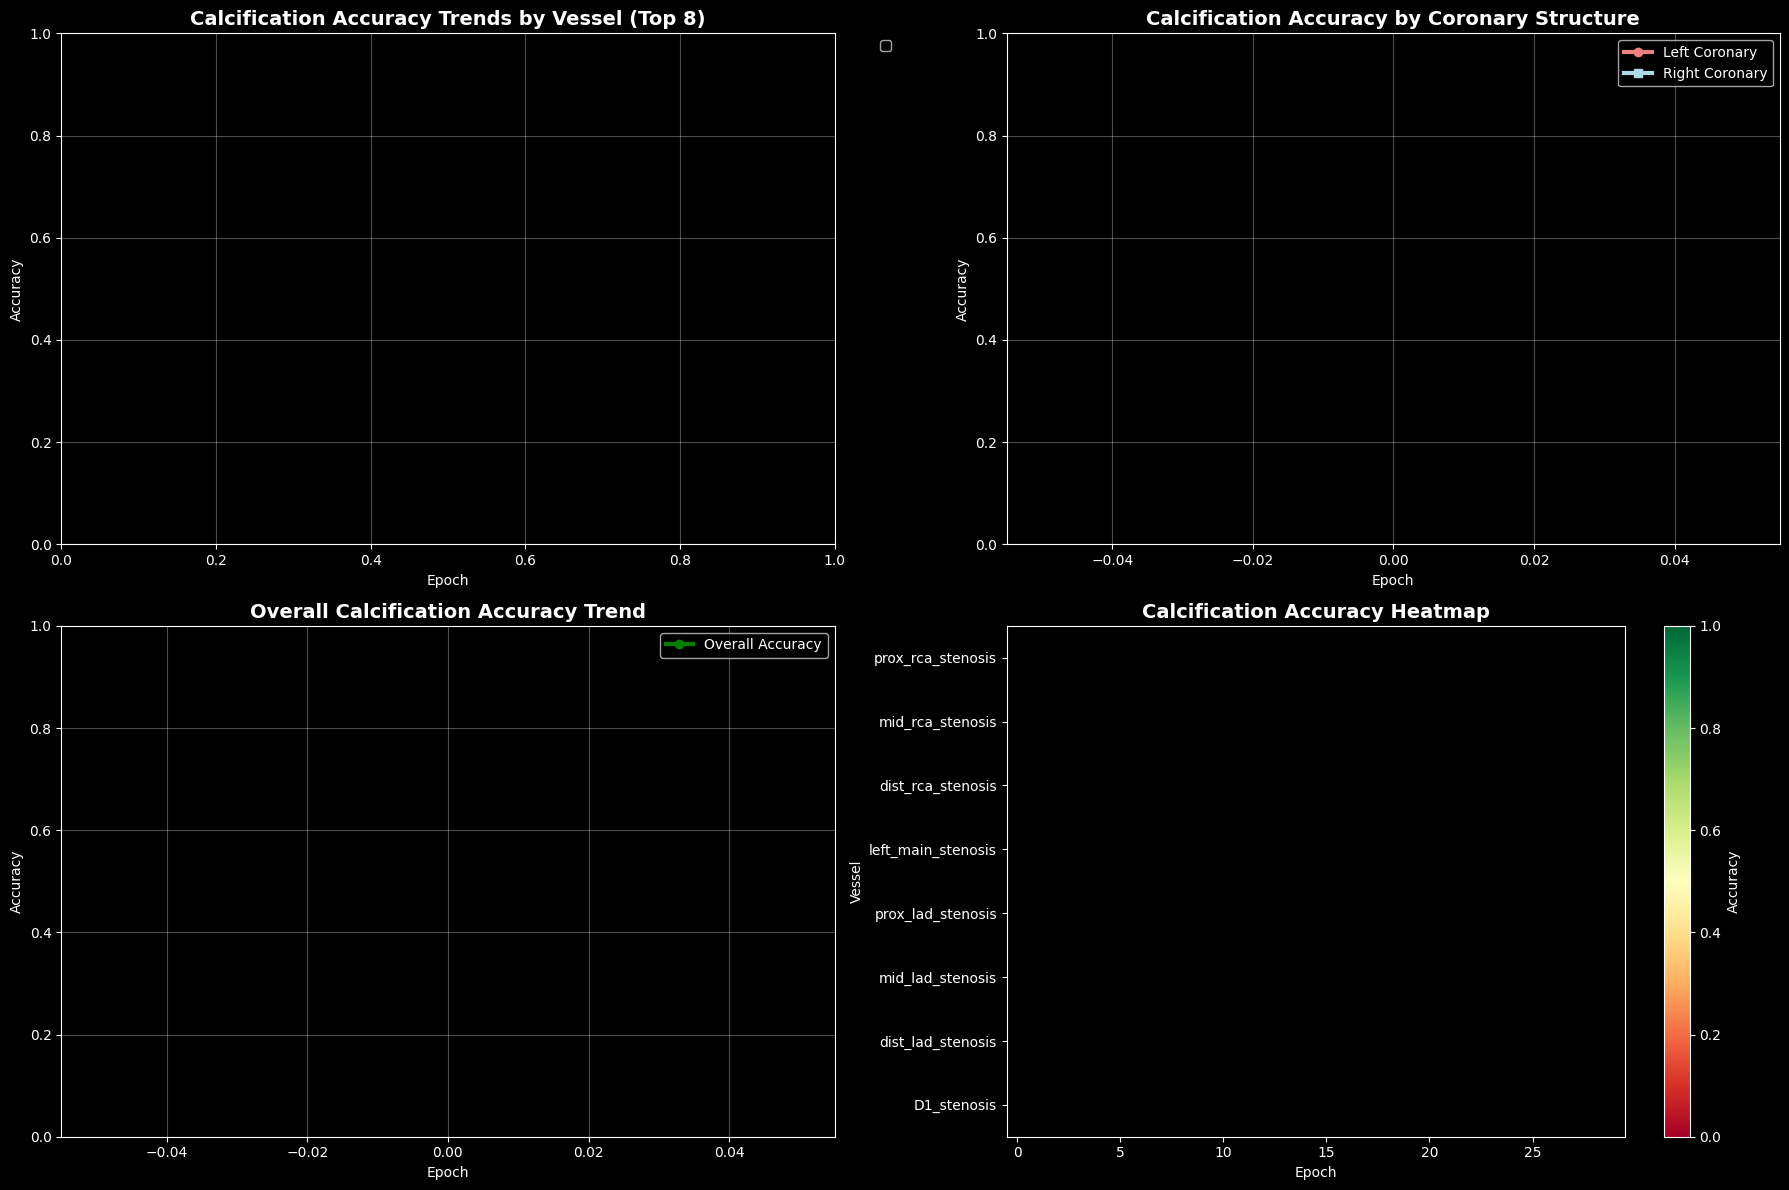


🦴 CALCIFICATION PERFORMANCE SUMMARY:


ValueError: All-NaN slice encountered

In [7]:
# 🦴 Step 4: Calcification Accuracy Trends Over Epochs
print("\n" + "="*60)
print("🦴 STEP 4: Calcification Accuracy Trends Over Epochs")
print("="*60)

if calcification_metrics and epoch_nums:
    print("🦴 Creating calcification accuracy trend visualizations...")
    
    # Create calcification analysis plots
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Accuracy trends by vessel (top vessels only)
    plt.subplot(2, 2, 1)
    vessel_importance = []  # Calculate vessel importance by data availability
    for vessel in calcification_metrics.keys():
        acc_values = [calcification_metrics[vessel][epoch].get('accuracy', np.nan) for epoch in epoch_nums]
        valid_count = sum(1 for v in acc_values if not np.isnan(v))
        vessel_importance.append((vessel, valid_count))
    
    # Plot top 8 vessels by data availability
    top_vessels = sorted(vessel_importance, key=lambda x: x[1], reverse=True)[:8]
    colors = plt.cm.Set2(np.linspace(0, 1, 8))
    
    for i, (vessel, _) in enumerate(top_vessels):
        acc_values = [calcification_metrics[vessel][epoch].get('accuracy', np.nan) for epoch in epoch_nums]
        valid_epochs = [epoch_nums[j] for j, v in enumerate(acc_values) if not np.isnan(v)]
        valid_accs = [v for v in acc_values if not np.isnan(v)]
        
        if valid_accs:
            plt.plot(valid_epochs, valid_accs, 'o-', label=vessel.replace('_calcification', ''), 
                    color=colors[i], linewidth=2, markersize=4)
    
    plt.title('Calcification Accuracy Trends by Vessel (Top 8)', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy trends by coronary structure
    plt.subplot(2, 2, 2)
    from utils.vessel_constants import RCA_VESSELS, NON_RCA_VESSELS
    
    # Calculate structure-wise metrics
    left_acc_means = []
    right_acc_means = []
    
    for epoch in epoch_nums:
        left_accs = [calcification_metrics[v][epoch].get('accuracy', np.nan) for v in NON_RCA_VESSELS if v in calcification_metrics]
        right_accs = [calcification_metrics[v][epoch].get('accuracy', np.nan) for v in RCA_VESSELS if v in calcification_metrics]
        
        left_acc_means.append(np.nanmean(left_accs) if left_accs else np.nan)
        right_acc_means.append(np.nanmean(right_accs) if right_accs else np.nan)
    
    plt.plot(epoch_nums, left_acc_means, 'o-', label='Left Coronary', color='lightcoral', linewidth=3, markersize=6)
    plt.plot(epoch_nums, right_acc_means, 's-', label='Right Coronary', color='lightblue', linewidth=3, markersize=6)
    
    plt.title('Calcification Accuracy by Coronary Structure', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Overall calcification accuracy trend
    plt.subplot(2, 2, 3)
    all_acc_means = []
    
    for epoch in epoch_nums:
        all_accs = []
        for vessel in calcification_metrics.keys():
            acc = calcification_metrics[vessel][epoch].get('accuracy', np.nan)
            if not np.isnan(acc):
                all_accs.append(acc)
        
        all_acc_means.append(np.mean(all_accs) if all_accs else np.nan)
    
    plt.plot(epoch_nums, all_acc_means, 'o-', color='green', linewidth=3, markersize=6, label='Overall Accuracy')
    
    # Add trend line
    valid_epochs = [epoch_nums[i] for i, v in enumerate(all_acc_means) if not np.isnan(v)]
    valid_accs = [v for v in all_acc_means if not np.isnan(v)]
    
    if len(valid_epochs) > 1:
        z = np.polyfit(valid_epochs, valid_accs, 1)
        p = np.poly1d(z)
        plt.plot(valid_epochs, p(valid_epochs), "--", color='red', alpha=0.7, label=f'Trend (slope: {z[0]:.4f})')
    
    plt.title('Overall Calcification Accuracy Trend', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Calcification accuracy heatmap
    plt.subplot(2, 2, 4)
    acc_matrix = []
    vessel_labels = []
    
    for vessel, _ in top_vessels:
        acc_row = [calcification_metrics[vessel][epoch].get('accuracy', np.nan) for epoch in epoch_nums]
        acc_matrix.append(acc_row)
        vessel_labels.append(vessel.replace('_calcification', ''))
    
    acc_matrix = np.array(acc_matrix)
    # Mask NaN values
    mask = np.isnan(acc_matrix)
    
    im = plt.imshow(acc_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(im, label='Accuracy')
    plt.yticks(range(len(vessel_labels)), vessel_labels)
    plt.xticks(range(0, len(epoch_nums), 5), [str(epoch_nums[i]) for i in range(0, len(epoch_nums), 5)])
    plt.xlabel('Epoch')
    plt.ylabel('Vessel')
    plt.title('Calcification Accuracy Heatmap', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print calcification summary
    print(f"\n🦴 CALCIFICATION PERFORMANCE SUMMARY:")
    if all_acc_means:
        best_acc_epoch = epoch_nums[np.nanargmax(all_acc_means)]
        worst_acc_epoch = epoch_nums[np.nanargmin(all_acc_means)]
        print(f"   🎯 Best Overall Accuracy: {np.nanmax(all_acc_means):.3f} (Epoch {best_acc_epoch})")
        print(f"   📉 Worst Overall Accuracy: {np.nanmin(all_acc_means):.3f} (Epoch {worst_acc_epoch})")
        
        improvement = np.nanmax(all_acc_means) - np.nanmin(all_acc_means)
        print(f"   📈 Accuracy Improvement: {improvement:.3f} ({improvement*100:.1f}%)")
        
        # Calculate average accuracy
        avg_accuracy = np.nanmean(all_acc_means)
        print(f"   📊 Average Accuracy Across All Epochs: {avg_accuracy:.3f}")
        
        # Trend analysis
        if len(valid_epochs) > 1:
            from scipy.stats import pearsonr
            trend_corr, trend_p = pearsonr(valid_epochs, valid_accs)
            print(f"   📈 Trend Correlation: {trend_corr:.3f} (p={trend_p:.3f})")
            if trend_corr > 0.1:
                print("      📈 Positive trend - calcification accuracy improving over epochs")
            elif trend_corr < -0.1:
                print("      📉 Negative trend - calcification accuracy declining over epochs")
            else:
                print("      ➡️ Stable performance - no clear trend")
    
else:
    print("❌ No calcification metrics available for trend analysis!")



💉 STEP 5: IFR Performance Trends Over Epochs
💉 Creating IFR performance trend visualizations...


/tmp/ipykernel_330116/1837739499.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
/tmp/ipykernel_330116/1837739499.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
/tmp/ipykernel_330116/1837739499.py:72: RuntimeWarning: Mean of empty slice
  left_mae_means.append(np.nanmean(left_maes) if left_maes else np.nan)
/tmp/ipykernel_330116/1837739499.py:73: RuntimeWarning: Mean of empty slice
  right_mae_means.append(np.nanmean(right_maes) if right_maes else np.nan)
/tmp/ipykernel_330116/1837739499.py:74: RuntimeWarning: Mean of empty slice
  left_corr_means.append(np.nanmean(left_corrs) if left_corrs else np.nan)
/tmp/ipykernel_3

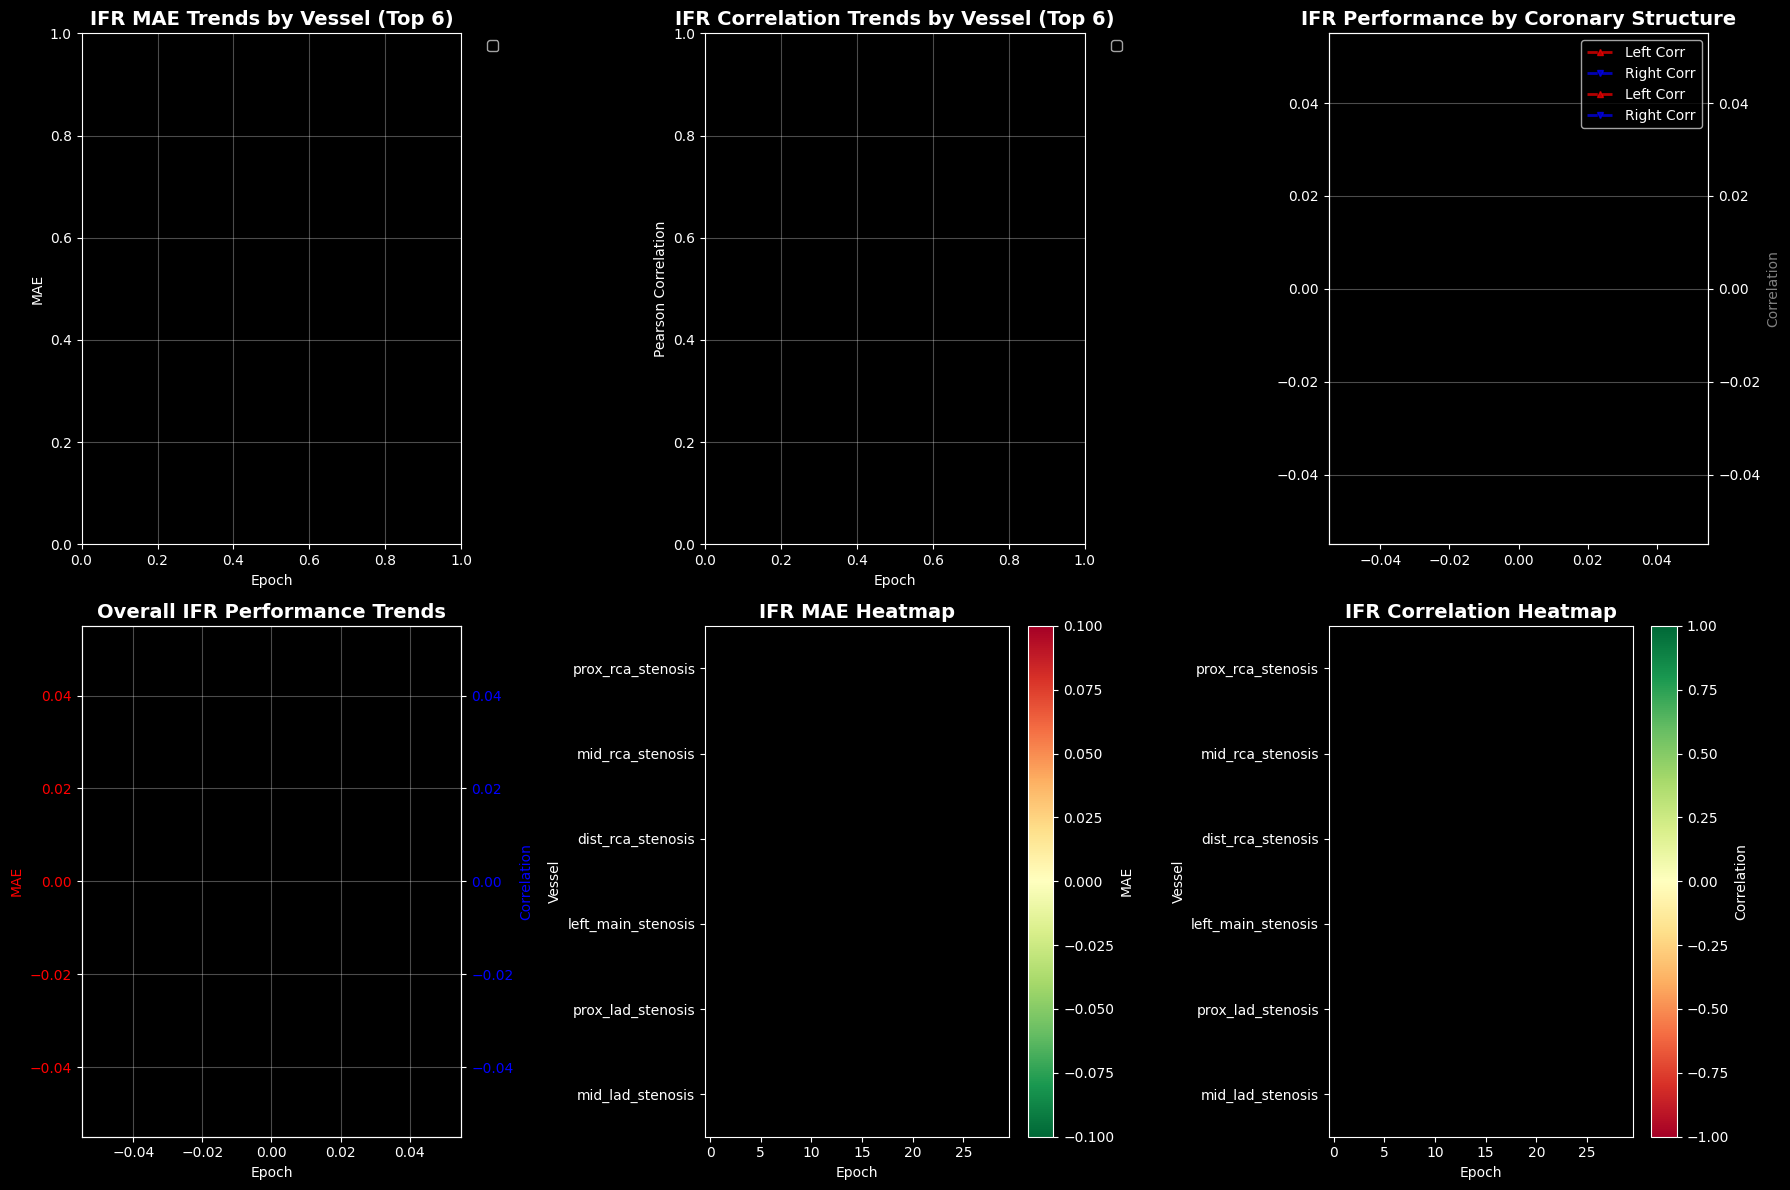


💉 IFR PERFORMANCE SUMMARY:


ValueError: All-NaN slice encountered

In [8]:
# 💉 Step 5: IFR Performance Trends Over Epochs
print("\n" + "="*60)
print("💉 STEP 5: IFR Performance Trends Over Epochs")
print("="*60)

if ifr_metrics and epoch_nums:
    print("💉 Creating IFR performance trend visualizations...")
    
    # Create IFR analysis plots
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: IFR MAE trends by vessel (top vessels only)
    plt.subplot(2, 3, 1)
    vessel_importance = []  # Calculate vessel importance by data availability
    for vessel in ifr_metrics.keys():
        mae_values = [ifr_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        valid_count = sum(1 for v in mae_values if not np.isnan(v))
        vessel_importance.append((vessel, valid_count))
    
    # Plot top 6 vessels by data availability
    top_vessels = sorted(vessel_importance, key=lambda x: x[1], reverse=True)[:6]
    colors = plt.cm.tab10(np.linspace(0, 1, 6))
    
    for i, (vessel, _) in enumerate(top_vessels):
        mae_values = [ifr_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        valid_epochs = [epoch_nums[j] for j, v in enumerate(mae_values) if not np.isnan(v)]
        valid_maes = [v for v in mae_values if not np.isnan(v)]
        
        if valid_maes:
            plt.plot(valid_epochs, valid_maes, 'o-', label=vessel.replace('_ifr', ''), 
                    color=colors[i], linewidth=2, markersize=4)
    
    plt.title('IFR MAE Trends by Vessel (Top 6)', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: IFR Correlation trends by vessel
    plt.subplot(2, 3, 2)
    for i, (vessel, _) in enumerate(top_vessels):
        corr_values = [ifr_metrics[vessel][epoch].get('corr', np.nan) for epoch in epoch_nums]
        valid_epochs = [epoch_nums[j] for j, v in enumerate(corr_values) if not np.isnan(v)]
        valid_corrs = [v for v in corr_values if not np.isnan(v)]
        
        if valid_corrs:
            plt.plot(valid_epochs, valid_corrs, 'o-', label=vessel.replace('_ifr', ''), 
                    color=colors[i], linewidth=2, markersize=4)
    
    plt.title('IFR Correlation Trends by Vessel (Top 6)', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: IFR trends by coronary structure
    plt.subplot(2, 3, 3)
    from utils.vessel_constants import RCA_VESSELS, NON_RCA_VESSELS
    
    # Calculate structure-wise metrics
    left_mae_means = []
    right_mae_means = []
    left_corr_means = []
    right_corr_means = []
    
    for epoch in epoch_nums:
        left_maes = [ifr_metrics[v][epoch].get('mae', np.nan) for v in NON_RCA_VESSELS if v in ifr_metrics]
        right_maes = [ifr_metrics[v][epoch].get('mae', np.nan) for v in RCA_VESSELS if v in ifr_metrics]
        left_corrs = [ifr_metrics[v][epoch].get('corr', np.nan) for v in NON_RCA_VESSELS if v in ifr_metrics]
        right_corrs = [ifr_metrics[v][epoch].get('corr', np.nan) for v in RCA_VESSELS if v in ifr_metrics]
        
        left_mae_means.append(np.nanmean(left_maes) if left_maes else np.nan)
        right_mae_means.append(np.nanmean(right_maes) if right_maes else np.nan)
        left_corr_means.append(np.nanmean(left_corrs) if left_corrs else np.nan)
        right_corr_means.append(np.nanmean(right_corrs) if right_corrs else np.nan)
    
    plt.plot(epoch_nums, left_mae_means, 'o-', label='Left MAE', color='lightcoral', linewidth=2, markersize=5)
    plt.plot(epoch_nums, right_mae_means, 's-', label='Right MAE', color='lightblue', linewidth=2, markersize=5)
    
    # Add correlation on secondary y-axis
    ax2 = plt.gca().twinx()
    ax2.plot(epoch_nums, left_corr_means, '^--', label='Left Corr', color='red', linewidth=2, markersize=5, alpha=0.7)
    ax2.plot(epoch_nums, right_corr_means, 'v--', label='Right Corr', color='blue', linewidth=2, markersize=5, alpha=0.7)
    
    plt.title('IFR Performance by Coronary Structure', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE', color='black')
    ax2.set_ylabel('Correlation', color='gray')
    
    # Combine legends
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Overall IFR performance trend
    plt.subplot(2, 3, 4)
    all_mae_means = []
    all_corr_means = []
    
    for epoch in epoch_nums:
        all_maes = []
        all_corrs = []
        for vessel in ifr_metrics.keys():
            mae = ifr_metrics[vessel][epoch].get('mae', np.nan)
            corr = ifr_metrics[vessel][epoch].get('corr', np.nan)
            if not np.isnan(mae):
                all_maes.append(mae)
            if not np.isnan(corr):
                all_corrs.append(corr)
        
        all_mae_means.append(np.mean(all_maes) if all_maes else np.nan)
        all_corr_means.append(np.mean(all_corrs) if all_corrs else np.nan)
    
    plt.plot(epoch_nums, all_mae_means, 'o-', color='red', linewidth=3, markersize=6, label='Overall MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE', color='red')
    plt.tick_params(axis='y', labelcolor='red')
    plt.grid(True, alpha=0.3)
    
    # Create second y-axis for correlation
    ax2 = plt.gca().twinx()
    ax2.plot(epoch_nums, all_corr_means, 's-', color='blue', linewidth=3, markersize=6, label='Overall Correlation')
    ax2.set_ylabel('Correlation', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    plt.title('Overall IFR Performance Trends', fontweight='bold', fontsize=14)
    
    # Plot 5: IFR MAE heatmap
    plt.subplot(2, 3, 5)
    mae_matrix = []
    vessel_labels = []
    
    for vessel, _ in top_vessels:
        mae_row = [ifr_metrics[vessel][epoch].get('mae', np.nan) for epoch in epoch_nums]
        mae_matrix.append(mae_row)
        vessel_labels.append(vessel.replace('_ifr', ''))
    
    mae_matrix = np.array(mae_matrix)
    
    im = plt.imshow(mae_matrix, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(im, label='MAE')
    plt.yticks(range(len(vessel_labels)), vessel_labels)
    plt.xticks(range(0, len(epoch_nums), 5), [str(epoch_nums[i]) for i in range(0, len(epoch_nums), 5)])
    plt.xlabel('Epoch')
    plt.ylabel('Vessel')
    plt.title('IFR MAE Heatmap', fontweight='bold', fontsize=14)
    
    # Plot 6: IFR Correlation heatmap
    plt.subplot(2, 3, 6)
    corr_matrix = []
    
    for vessel, _ in top_vessels:
        corr_row = [ifr_metrics[vessel][epoch].get('corr', np.nan) for epoch in epoch_nums]
        corr_matrix.append(corr_row)
    
    corr_matrix = np.array(corr_matrix)
    
    im = plt.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.yticks(range(len(vessel_labels)), vessel_labels)
    plt.xticks(range(0, len(epoch_nums), 5), [str(epoch_nums[i]) for i in range(0, len(epoch_nums), 5)])
    plt.xlabel('Epoch')
    plt.ylabel('Vessel')
    plt.title('IFR Correlation Heatmap', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print IFR summary
    print(f"\n💉 IFR PERFORMANCE SUMMARY:")
    if all_mae_means:
        best_mae_epoch = epoch_nums[np.nanargmin(all_mae_means)]
        worst_mae_epoch = epoch_nums[np.nanargmax(all_mae_means)]
        print(f"   🎯 Best Overall MAE: {np.nanmin(all_mae_means):.4f} (Epoch {best_mae_epoch})")
        print(f"   📉 Worst Overall MAE: {np.nanmax(all_mae_means):.4f} (Epoch {worst_mae_epoch})")
        
        improvement = np.nanmax(all_mae_means) - np.nanmin(all_mae_means)
        print(f"   📈 MAE Improvement: {improvement:.4f} ({improvement/np.nanmax(all_mae_means)*100:.1f}%)")
    
    if all_corr_means:
        best_corr_epoch = epoch_nums[np.nanargmax(all_corr_means)]
        worst_corr_epoch = epoch_nums[np.nanargmin(all_corr_means)]
        print(f"   🔗 Best Overall Correlation: {np.nanmax(all_corr_means):.3f} (Epoch {best_corr_epoch})")
        print(f"   📉 Worst Overall Correlation: {np.nanmin(all_corr_means):.3f} (Epoch {worst_corr_epoch})")
        
        # Calculate average correlation
        avg_correlation = np.nanmean(all_corr_means)
        print(f"   📊 Average Correlation Across All Epochs: {avg_correlation:.3f}")
        
        # Trend analysis
        valid_epochs = [epoch_nums[i] for i, v in enumerate(all_corr_means) if not np.isnan(v)]
        valid_corrs = [v for v in all_corr_means if not np.isnan(v)]
        
        if len(valid_epochs) > 1:
            from scipy.stats import pearsonr
            trend_corr, trend_p = pearsonr(valid_epochs, valid_corrs)
            print(f"   📈 Correlation Trend: {trend_corr:.3f} (p={trend_p:.3f})")
            if trend_corr > 0.1:
                print("      📈 Positive trend - IFR correlation improving over epochs")
            elif trend_corr < -0.1:
                print("      📉 Negative trend - IFR correlation declining over epochs")
            else:
                print("      ➡️ Stable performance - no clear trend")
    
else:
    print("❌ No IFR metrics available for trend analysis!")



📊 STEP 6: Combined Performance Analysis and Summary
📊 Creating combined performance analysis...


/tmp/ipykernel_330116/2801235595.py:172: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_330116/2801235595.py:172: UserWarning: Glyph 129728 (\N{ANATOMICAL HEART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_330116/2801235595.py:172: UserWarning: Glyph 129460 (\N{BONE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_330116/2801235595.py:172: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_330116/2801235595.py:172: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/IPython/core/pylabt

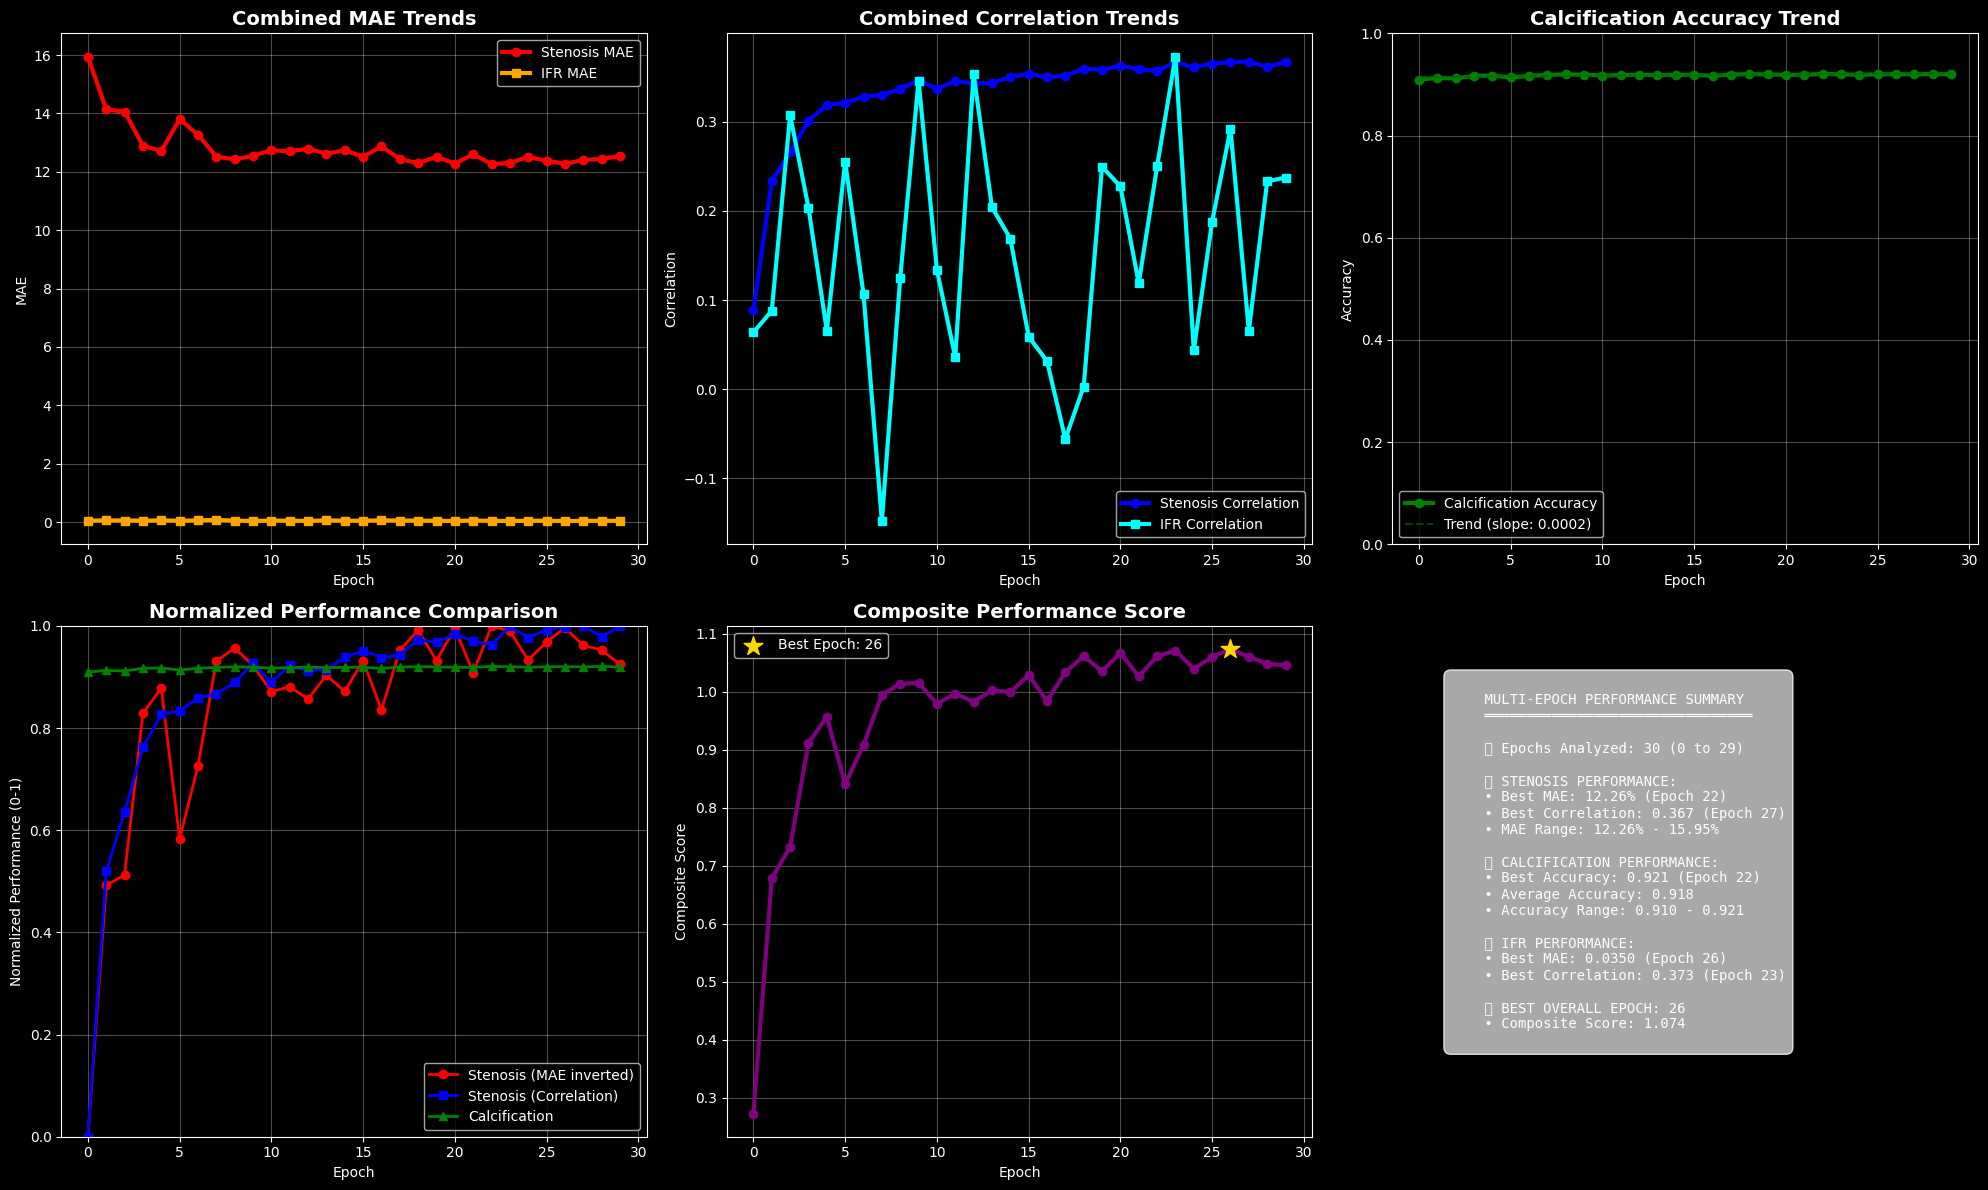


📊 COMPREHENSIVE SUMMARY:
   🏆 Best Overall Epoch: 26 (Score: 1.074)
   📈 Stenosis: MAE 12.28%, Corr 0.367
   🦴 Calcification: Accuracy 0.920
   💉 IFR: MAE 0.0350, Corr 0.292
   💾 Summary saved: multi_epoch_study_analysis_results/comprehensive_epoch_summary.csv

🎉 MULTI-EPOCH STUDY ANALYSIS COMPLETED!


In [9]:
# 📊 Step 6: Combined Performance Analysis and Summary
print("\n" + "="*60)
print("📊 STEP 6: Combined Performance Analysis and Summary")
print("="*60)

if all_epoch_metrics and epoch_nums:
    print("📊 Creating combined performance analysis...")
    
    # Calculate overall metrics for each epoch
    overall_metrics = {}
    
    for epoch in epoch_nums:
        epoch_key = f"epoch_{epoch}"
        metrics = all_epoch_metrics[epoch_key]
        
        # Stenosis metrics
        stenosis_mae = metrics.get('stenosis', {}).get('mae', {})
        stenosis_corr = metrics.get('stenosis', {}).get('corr', {})
        
        # Calcification metrics
        calcif_acc = metrics.get('calcification', {}).get('accuracy', {})
        
        # IFR metrics
        ifr_mae = metrics.get('ifr', {}).get('mae', {})
        ifr_corr = metrics.get('ifr', {}).get('corr', {})
        
        # Calculate averages
        overall_metrics[epoch] = {
            'stenosis_mae': np.nanmean(list(stenosis_mae.values())),
            'stenosis_corr': np.nanmean(list(stenosis_corr.values())),
            'calcification_acc': np.nanmean(list(calcif_acc.values())),
            'ifr_mae': np.nanmean(list(ifr_mae.values())),
            'ifr_corr': np.nanmean(list(ifr_corr.values()))
        }
    
    # Create combined visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Combined MAE trends
    plt.subplot(2, 3, 1)
    stenosis_maes = [overall_metrics[e]['stenosis_mae'] for e in epoch_nums]
    ifr_maes = [overall_metrics[e]['ifr_mae'] for e in epoch_nums]
    
    plt.plot(epoch_nums, stenosis_maes, 'o-', label='Stenosis MAE', color='red', linewidth=3, markersize=6)
    plt.plot(epoch_nums, ifr_maes, 's-', label='IFR MAE', color='orange', linewidth=3, markersize=6)
    
    plt.title('Combined MAE Trends', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Combined correlation trends
    plt.subplot(2, 3, 2)
    stenosis_corrs = [overall_metrics[e]['stenosis_corr'] for e in epoch_nums]
    ifr_corrs = [overall_metrics[e]['ifr_corr'] for e in epoch_nums]
    
    plt.plot(epoch_nums, stenosis_corrs, 'o-', label='Stenosis Correlation', color='blue', linewidth=3, markersize=6)
    plt.plot(epoch_nums, ifr_corrs, 's-', label='IFR Correlation', color='cyan', linewidth=3, markersize=6)
    
    plt.title('Combined Correlation Trends', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Calcification accuracy trend
    plt.subplot(2, 3, 3)
    calcif_accs = [overall_metrics[e]['calcification_acc'] for e in epoch_nums]
    
    plt.plot(epoch_nums, calcif_accs, 'o-', label='Calcification Accuracy', color='green', linewidth=3, markersize=6)
    
    # Add trend line
    valid_epochs = [epoch_nums[i] for i, v in enumerate(calcif_accs) if not np.isnan(v)]
    valid_accs = [v for v in calcif_accs if not np.isnan(v)]
    
    if len(valid_epochs) > 1:
        z = np.polyfit(valid_epochs, valid_accs, 1)
        p = np.poly1d(z)
        plt.plot(valid_epochs, p(valid_epochs), "--", color='darkgreen', alpha=0.7, label=f'Trend (slope: {z[0]:.4f})')
    
    plt.title('Calcification Accuracy Trend', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Performance improvement over time
    plt.subplot(2, 3, 4)
    
    # Normalize all metrics to 0-1 range for comparison
    norm_stenosis_mae = 1 - (np.array(stenosis_maes) - np.nanmin(stenosis_maes)) / (np.nanmax(stenosis_maes) - np.nanmin(stenosis_maes))
    norm_stenosis_corr = (np.array(stenosis_corrs) - np.nanmin(stenosis_corrs)) / (np.nanmax(stenosis_corrs) - np.nanmin(stenosis_corrs))
    norm_calcif_acc = np.array(calcif_accs)
    
    plt.plot(epoch_nums, norm_stenosis_mae, 'o-', label='Stenosis (MAE inverted)', color='red', linewidth=2)
    plt.plot(epoch_nums, norm_stenosis_corr, 's-', label='Stenosis (Correlation)', color='blue', linewidth=2)
    plt.plot(epoch_nums, norm_calcif_acc, '^-', label='Calcification', color='green', linewidth=2)
    
    plt.title('Normalized Performance Comparison', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Performance (0-1)')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Best epoch identification
    plt.subplot(2, 3, 5)
    
    # Calculate composite scores
    composite_scores = []
    for i, epoch in enumerate(epoch_nums):
        # Weight different metrics (you can adjust these weights)
        stenosis_weight = 0.4
        calcif_weight = 0.3
        ifr_weight = 0.3
        
        score = (norm_stenosis_mae[i] * stenosis_weight + 
                norm_stenosis_corr[i] * stenosis_weight + 
                norm_calcif_acc[i] * calcif_weight)
        
        composite_scores.append(score)
    
    plt.plot(epoch_nums, composite_scores, 'o-', color='purple', linewidth=3, markersize=6)
    
    # Mark best epoch
    best_epoch_idx = np.nanargmax(composite_scores)
    best_epoch = epoch_nums[best_epoch_idx]
    plt.scatter(best_epoch, composite_scores[best_epoch_idx], color='gold', s=200, marker='*', 
               label=f'Best Epoch: {best_epoch}', zorder=5)
    
    plt.title('Composite Performance Score', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Composite Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Summary table visualization
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create summary statistics
    summary_text = f"""
    MULTI-EPOCH PERFORMANCE SUMMARY
    ════════════════════════════════
    
    📊 Epochs Analyzed: {len(epoch_nums)} ({epoch_nums[0]} to {epoch_nums[-1]})
    
    🫀 STENOSIS PERFORMANCE:
    • Best MAE: {np.nanmin(stenosis_maes):.2f}% (Epoch {epoch_nums[np.nanargmin(stenosis_maes)]})
    • Best Correlation: {np.nanmax(stenosis_corrs):.3f} (Epoch {epoch_nums[np.nanargmax(stenosis_corrs)]})
    • MAE Range: {np.nanmin(stenosis_maes):.2f}% - {np.nanmax(stenosis_maes):.2f}%
    
    🦴 CALCIFICATION PERFORMANCE:
    • Best Accuracy: {np.nanmax(calcif_accs):.3f} (Epoch {epoch_nums[np.nanargmax(calcif_accs)]})
    • Average Accuracy: {np.nanmean(calcif_accs):.3f}
    • Accuracy Range: {np.nanmin(calcif_accs):.3f} - {np.nanmax(calcif_accs):.3f}
    
    💉 IFR PERFORMANCE:
    • Best MAE: {np.nanmin(ifr_maes):.4f} (Epoch {epoch_nums[np.nanargmin(ifr_maes)]})
    • Best Correlation: {np.nanmax(ifr_corrs):.3f} (Epoch {epoch_nums[np.nanargmax(ifr_corrs)]})
    
    🏆 BEST OVERALL EPOCH: {best_epoch}
    • Composite Score: {composite_scores[best_epoch_idx]:.3f}
    """
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Create and save comprehensive summary DataFrame
    summary_data = []
    for epoch in epoch_nums:
        summary_data.append({
            'epoch': epoch,
            'stenosis_mae': overall_metrics[epoch]['stenosis_mae'],
            'stenosis_corr': overall_metrics[epoch]['stenosis_corr'],
            'calcification_acc': overall_metrics[epoch]['calcification_acc'],
            'ifr_mae': overall_metrics[epoch]['ifr_mae'],
            'ifr_corr': overall_metrics[epoch]['ifr_corr'],
            'composite_score': composite_scores[epoch_nums.index(epoch)]
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_output = os.path.join(OUTPUT_DIR, "comprehensive_epoch_summary.csv")
    summary_df.to_csv(summary_output, index=False)
    
    print(f"\n📊 COMPREHENSIVE SUMMARY:")
    print(f"   🏆 Best Overall Epoch: {best_epoch} (Score: {composite_scores[best_epoch_idx]:.3f})")
    print(f"   📈 Stenosis: MAE {overall_metrics[best_epoch]['stenosis_mae']:.2f}%, Corr {overall_metrics[best_epoch]['stenosis_corr']:.3f}")
    print(f"   🦴 Calcification: Accuracy {overall_metrics[best_epoch]['calcification_acc']:.3f}")
    print(f"   💉 IFR: MAE {overall_metrics[best_epoch]['ifr_mae']:.4f}, Corr {overall_metrics[best_epoch]['ifr_corr']:.3f}")
    print(f"   💾 Summary saved: {summary_output}")
    
else:
    print("❌ No epoch metrics available for combined analysis!")

print("\n🎉 MULTI-EPOCH STUDY ANALYSIS COMPLETED!")
print("=" * 60)
